In [2]:
import random
import pickle
import torch

import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import HighwayPCH
from imitation.imitate import *

In [8]:
num_steps     = 10
train_eps     = 20
test_eps      = 10
seed          = 42
obs_prefix    = ['D','L','A','B','W']

# reproducibility
random.seed(seed)
torch.manual_seed(seed)

In [9]:
env = HighwayPCH(num_steps=num_steps, seed=seed, render_mode='rgb_array')

In [10]:
G = parse_graph(*env.env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [11]:
Z_sets = find_sequential_pi_backdoor(G, X, Y, obs_prefix)
Z_sets

{'X1': {'A0', 'A1', 'B0', 'B1', 'D0', 'D1', 'L0', 'L1', 'X0'},
 'X8': {'A0',
  'A1',
  'A2',
  'A3',
  'A4',
  'A5',
  'A6',
  'A7',
  'A8',
  'B0',
  'B1',
  'B2',
  'B3',
  'B4',
  'B5',
  'B6',
  'B7',
  'B8',
  'D0',
  'D1',
  'D2',
  'D3',
  'D4',
  'D5',
  'D6',
  'D7',
  'D8',
  'L0',
  'L1',
  'L2',
  'L3',
  'L4',
  'L5',
  'L6',
  'L7',
  'L8',
  'X0',
  'X1',
  'X2',
  'X3',
  'X4',
  'X5',
  'X6',
  'X7'},
 'X3': {'A0',
  'A1',
  'A2',
  'A3',
  'B0',
  'B1',
  'B2',
  'B3',
  'D0',
  'D1',
  'D2',
  'D3',
  'L0',
  'L1',
  'L2',
  'L3',
  'X0',
  'X1',
  'X2'},
 'X5': {'A0',
  'A1',
  'A2',
  'A3',
  'A4',
  'A5',
  'B0',
  'B1',
  'B2',
  'B3',
  'B4',
  'B5',
  'D0',
  'D1',
  'D2',
  'D3',
  'D4',
  'D5',
  'L0',
  'L1',
  'L2',
  'L3',
  'L4',
  'L5',
  'X0',
  'X1',
  'X2',
  'X3',
  'X4'},
 'X0': {'A0', 'B0', 'D0', 'L0'},
 'X6': {'A0',
  'A1',
  'A2',
  'A3',
  'A4',
  'A5',
  'A6',
  'B0',
  'B1',
  'B2',
  'B3',
  'B4',
  'B5',
  'B6',
  'D0',
  'D1',
  'D2',
  'D3

In [12]:
records = collect_expert_trajectories(
    env,
    num_episodes=train_eps,
    max_steps=num_steps,
    behavioral_policy=None,
    seed=seed
)

In [ ]:
with open('expert_traj.pkl', 'wb') as f:
    pickle.dump(records, f)

print(f'saved {len(records)} trajectories')

In [13]:
with open('expert_traj.pkl', 'rb') as f:
    records = pickle.load(f)

print(f'loaded {len(records)} trajectories')

loaded 1965 trajectories


In [15]:
for r in records:
    r['obs']['D'] = [1 if r['obs']['D'][i] < 20.0 else 0 for i in range(len(r['obs']['D']))]

In [18]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'D{j}', f'L{j}', f'A{j}', f'B{j}', f'W{j}'})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

In [19]:
causal_policies = train_policies(env, records, Z_sets, seed=seed)
naive_policies = train_policies(env, records, naive_Z_sets, seed=seed)

Stopping early at epoch 14; val_loss has not improved for 10 epochs.
Stopping early at epoch 78; val_loss has not improved for 10 epochs.
Stopping early at epoch 42; val_loss has not improved for 10 epochs.
Stopping early at epoch 93; val_loss has not improved for 10 epochs.
Stopping early at epoch 70; val_loss has not improved for 10 epochs.
Stopping early at epoch 64; val_loss has not improved for 10 epochs.
Stopping early at epoch 61; val_loss has not improved for 10 epochs.
Stopping early at epoch 16; val_loss has not improved for 10 epochs.
Stopping early at epoch 77; val_loss has not improved for 10 epochs.
Stopping early at epoch 71; val_loss has not improved for 10 epochs.
Stopping early at epoch 51; val_loss has not improved for 10 epochs.


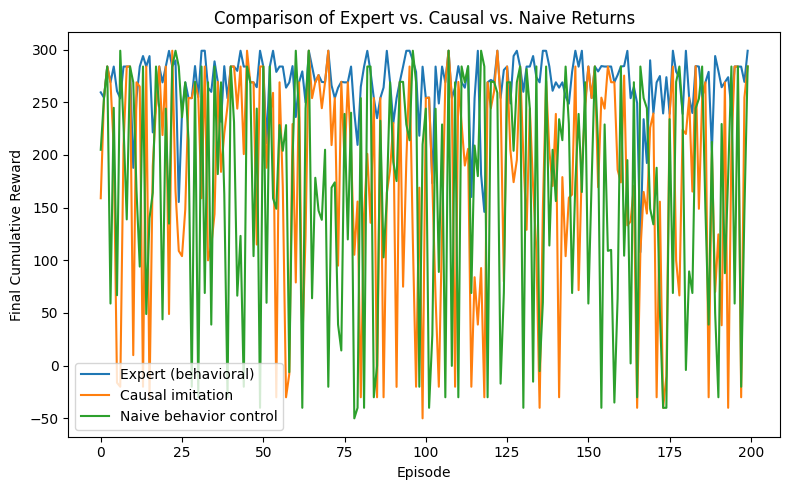

In [ ]:
episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    episode_rewards[ep] = rec['info']['Y'][-1]

num_eps = len(episode_rewards)

expert_returns = [episode_rewards[e] for e in range(num_eps)]

causal_returns = eval_policy(env, causal_policies, num_episodes=num_eps, seed=seed)
naive_returns  = eval_policy(env, naive_policies,  num_episodes=num_eps, seed=seed)

plt.figure(figsize=(8,5))
plt.plot(expert_returns, label='Expert (behavioral)')
plt.plot(causal_returns,  label='Causal imitation')
plt.plot(naive_returns,   label='Naive behavior control')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert vs. Causal vs. Naive Returns')
plt.legend()
plt.tight_layout()
plt.show()

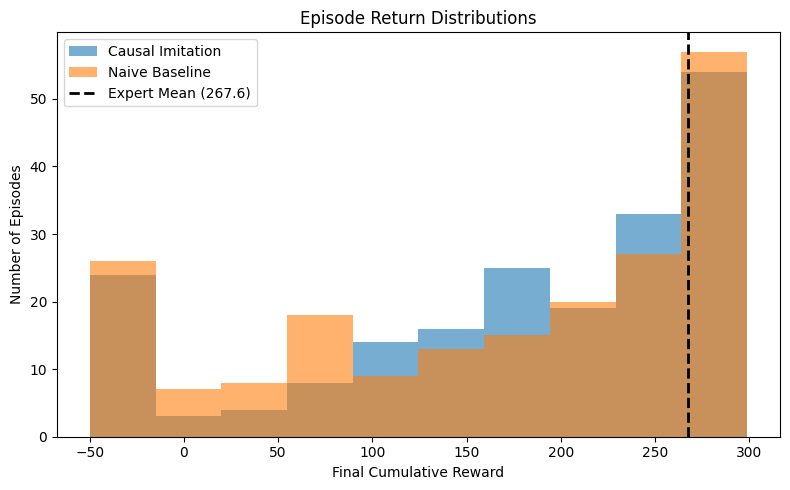

In [ ]:
plt.figure(figsize=(8,5))
bins = 10  # number of histogram bins

# plot histograms for causal and naive
plt.hist(causal_returns, bins=bins, alpha=0.6, label='Causal Imitation')
plt.hist(naive_returns,  bins=bins, alpha=0.6, label='Naive Baseline')

# compute and plot expert mean as a vertical line
expert_mean = np.mean(expert_returns)
plt.axvline(expert_mean, color='black', linestyle='--', linewidth=2, label=f'Expert Mean ({expert_mean:.1f})')

plt.xlabel('Final Cumulative Reward')
plt.ylabel('Number of Episodes')
plt.title('Episode Return Distributions')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
def policy_accuracy(records, policies):
    total, correct = 0, 0
    per_step = defaultdict(lambda: {'corr':0, 'total':0})

    for r in records:
        t = r['step']
        key = f'X{t}'
        if key not in policies:
            # no policy for this step—skip or count as incorrect
            continue
        pi_t = policies[key]
        pred = pi_t(r['obs'])
        true = r['action']

        per_step[t]['total']  += 1
        per_step[t]['corr']   += int(pred == true)
        total   += 1
        correct += int(pred == true)

    overall_acc = correct / total if total else float('nan')
    print(f"Overall accuracy: {overall_acc*100:.2f}% ({correct}/{total})")

    print("Per-step accuracy:")
    for t in sorted(per_step):
        ts = per_step[t]
        acc = ts['corr']/ts['total']
        print(f"  step {t}: {acc*100:.2f}% ({ts['corr']}/{ts['total']})")

    print()
    return overall_acc, per_step

# Example usage:
ci_acc, ci_step_acc = policy_accuracy(records, causal_policies)
bc_acc, bc_step_acc = policy_accuracy(records, naive_policies)

Overall accuracy: 84.48% (1660/1965)
Per-step accuracy:
  step 0: 97.00% (194/200)
  step 1: 97.50% (195/200)
  step 2: 78.50% (157/200)
  step 3: 94.00% (188/200)
  step 4: 87.94% (175/199)
  step 5: 81.91% (163/199)
  step 6: 88.78% (174/196)
  step 7: 82.90% (160/193)
  step 8: 54.45% (104/191)
  step 9: 80.21% (150/187)

Overall accuracy: 85.29% (1676/1965)
Per-step accuracy:
  step 0: 97.00% (194/200)
  step 1: 97.50% (195/200)
  step 2: 93.00% (186/200)
  step 3: 89.50% (179/200)
  step 4: 90.45% (180/199)
  step 5: 58.79% (117/199)
  step 6: 88.27% (173/196)
  step 7: 86.53% (167/193)
  step 8: 82.20% (157/191)
  step 9: 68.45% (128/187)



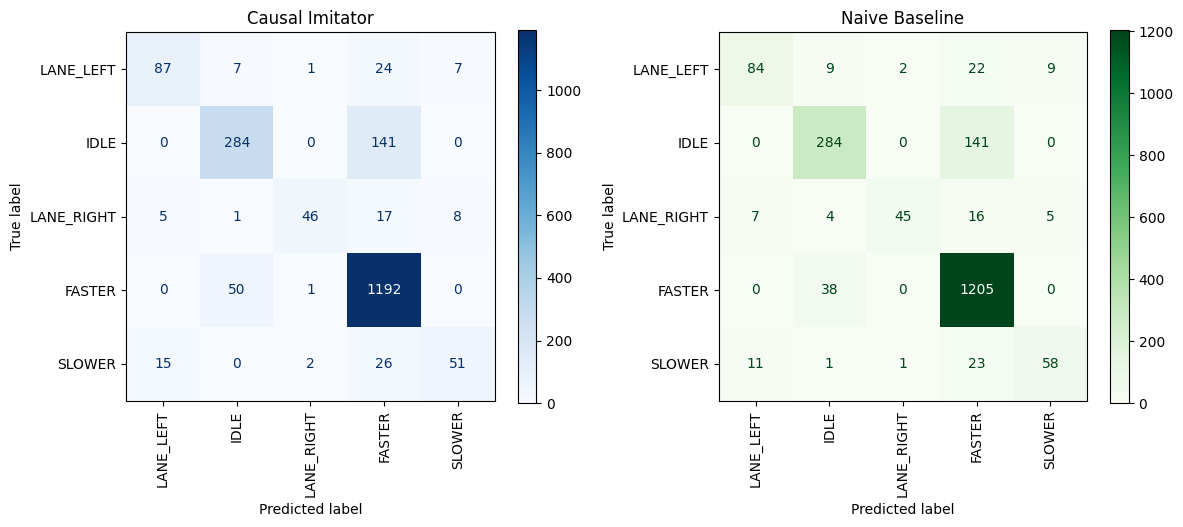

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare label and display names
n_actions = env.env.action_space.n
labels = list(range(n_actions))
action_names = list(env.env.unwrapped.action_type.actions.keys())

# Gather true actions once
y_true = []
for r in records:
    y_true.append(r['action'])

# Gather predictions for causal and naive
y_pred_causal = []
y_pred_naive  = []
for r in records:
    t = r['step']
    key = f'X{t}'
    # causal
    if key in causal_policies:
        y_pred_causal.append(causal_policies[key](r['obs']))
    else:
        y_pred_causal.append(-1)  # or some placeholder
    # naive
    if key in naive_policies:
        y_pred_naive.append(naive_policies[key](r['obs']))
    else:
        y_pred_naive.append(-1)

# Compute confusion matrices (we’ll ignore the placeholder label -1)
cm_causal = confusion_matrix(y_true, y_pred_causal, labels=labels)
cm_naive  = confusion_matrix(y_true, y_pred_naive,  labels=labels)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

action_names = [env.env._meta_actions.ACTIONS_ALL[a] for a in action_names]

disp1 = ConfusionMatrixDisplay(cm_causal, display_labels=action_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical')
ax1.set_title("Causal Imitator")

disp2 = ConfusionMatrixDisplay(cm_naive, display_labels=action_names)
disp2.plot(ax=ax2, cmap='Greens', xticks_rotation='vertical')
ax2.set_title("Naive Baseline")

plt.tight_layout()
plt.show()